In [1]:
""" 
Try PCA on simulation 2
"""

' \nTry PCA on simulation 2\n'

In [2]:
%matplotlib widget

import sys
sys.path.append("/home/wanxinli/EHR-OT/synthetic_exp")

from common import *
from EHR-OT.sda import SDA
from math import floor, exp
import matplotlib.pyplot as plt
import numpy as np
from numpy.random import dirichlet
import ot
from numpy.random import poisson
import pandas as pd
from random import randint
from scipy import sparse
from sklearn import linear_model
from sklearn import metrics
from sklearn import svm
from sklearn.decomposition import PCA

base_dir = "/home/wanxinli/EHR-OT"

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


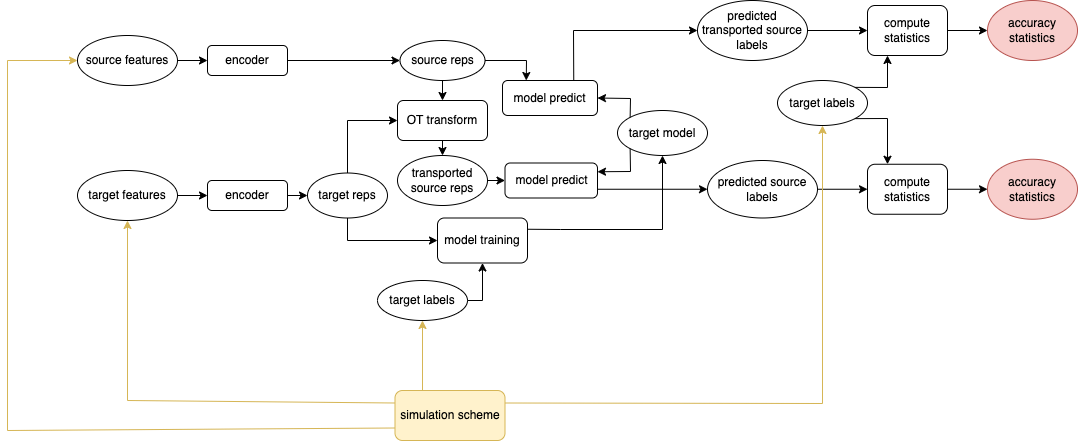

In [3]:
from IPython.display import Image
Image(filename='../outputs/EHR_sim_pipeline.png')

In [4]:
""" 
Simulation scheme
"""

def simulate(D, d_1, d_2, num_patient):
    """ 
    Simulate features and labels for domain 1 and domain 2
    :param int D:  total number of features
    :param int d_1: number of features with higher frequency in domain 1
    :param int d_2: number of features with higher frequency in domain 2
    :param int num_patient: number of patients in each domain

    Variables in the implementation are consistent with the variables in the scheme


    :return
        list[list[int]] domain 1 feature vectors
        list[int] domain 1 labels
        list[list[int]] domain 2 feature vectors
        list[int] domain 2 labels
    """

    d_1 = randint(0, floor(0.25*D))
    d_2 = randint(0, floor(0.25*D))
    delta_1 = np.random.choice(size = d_1, a = range(1, D+1), replace=False)
    remaining_set = list(set(list(range(1, D+1)))-set(delta_1))
    delta_2 = np.random.choice(size = d_1, a = remaining_set, replace=False)
    
    # We set the proportions of d_1 codes, d_2 codes, and (D-d_1-d_2) codes to be 2:1:1.5
    unit_1 = 1/(0.5*d_1-0.5*d_2+1.5*D)
    alpha_1 = [2*unit_1]*d_1
    alpha_1.extend([unit_1]*d_2)
    alpha_1.extend([1.5*unit_1]*(D-d_1-d_2))

    # We set the proportions of d_1 codes, d_2 codes, and (D-d_1-d_2) codes to be 1:2:1.5
    unit_2 = 1/(-0.5*d_1+0.5*d_2+1.5*D)
    alpha_2 = [2*unit_2]*d_1
    alpha_2.extend([unit_2]*d_2)
    alpha_2.extend([1.5*unit_2]*(D-d_1-d_2))  

    W = np.random.normal(size=D)
    W = [max(0, W_k) for W_k in W] # one W for the both domains

    def gen_feature_vector_label(alpha):
        """ 
        Generate feature vectors and labels
        :param list[float] alpha: concentration parameteres for the dirichlet distribution
        """

        def sigmoid(x):
            return 1 / (1 + exp(-x))

        rho = dirichlet(alpha=alpha, size=1)[0]
        
        X = []
        Y = []
        b = 0
        all_sum = []

        for _ in range(num_patient):
            X_i = np.random.multinomial(3*len(rho), rho)
            for k in range(len(X_i)):
                if X_i[k] > 0:
                    X_i[k] = 1 # dominant effect
            X.append(X_i)
            lambda_i= np.sum(np.multiply(W, X_i))
            Y_i = poisson(lam = lambda_i)
            Y.append(Y_i)
      
        return X, Y, W, b
    
    def feature_vector_to_feature(feature_vectors):
        """ 
        Convert feature vectors to features
        :param list[list[int]]: feature vectors consisting of indicators

        Returns
            - features consisting of actual codes
        """
        features = []
        for feature_vector in feature_vectors:
            features.append([i for i, e in enumerate(feature_vector) if e != 0])
        return features
    

    feature_vector_1, label_1, W_1, b_1 = gen_feature_vector_label(alpha_1)
    feature_vector_2, label_2, W_2, b_2 = gen_feature_vector_label(alpha_2)
    return feature_vector_1, np.array(label_1), feature_vector_2, np.array(label_2)



In [5]:
def simulation_wrapper():
    num_patient = 1000
    D = 20
    d_1 = 8
    d_2 = 8
    return simulate(D, d_1, d_2, num_patient)

In [6]:
"""
Train deep patient model and generate representations for targets and sources
"""

def custom_train_reps(target_features, source_features):
    target_pca = PCA(n_components=2)
    target_reps = target_pca.fit_transform(target_features)
    source_pca = PCA(n_components=2)
    source_reps = source_pca.fit_transform(source_features)
    return target_reps, source_reps

In [7]:
target_features, target_labels, source_features, source_labels = simulation_wrapper()
target_reps, source_reps = custom_train_reps(target_features, source_features)

In [8]:
target_maes, target_mses, target_rmses,  source_maes, source_mses, source_rmses, \
    trans_source_maes, trans_source_mses, trans_source_rmses = \
    run_proc_multi_cts(simulation_wrapper, custom_train_reps, linear_model.LogisticRegression, n_times = 100)

exception 2


/home/wanxinli/.local/lib/python3.8/site-packages/ot/bregman.py:517: UserWarning: Sinkhorn did not converge. You might want to increase the number of iterations `numItermax` or the regularization parameter `reg`.
  warnings.warn("Sinkhorn did not converge. You might want to "


exception 2
exception 2
exception 2
exception 2
exception 2
exception 2
exception 2
exception 2
exception 2
exception 2
exception 1
exception 2
exception 2
exception 2
exception 2
exception 2
exception 2
exception 2
exception 2
exception 2
exception 2
exception 2


In [9]:
score_path = "../outputs/sim5_lr_scores.csv"
save_scores_cts(target_maes, target_mses, target_rmses,  source_maes, source_mses, source_rmses, \
        trans_source_maes, trans_source_mses, trans_source_rmses, score_path)

average trans source to source mae is 98.7%
median trans source to source mae is 100.0%
average trans source to source rmse is 98.7%
median trans source to source rmse f1 is 100.0%


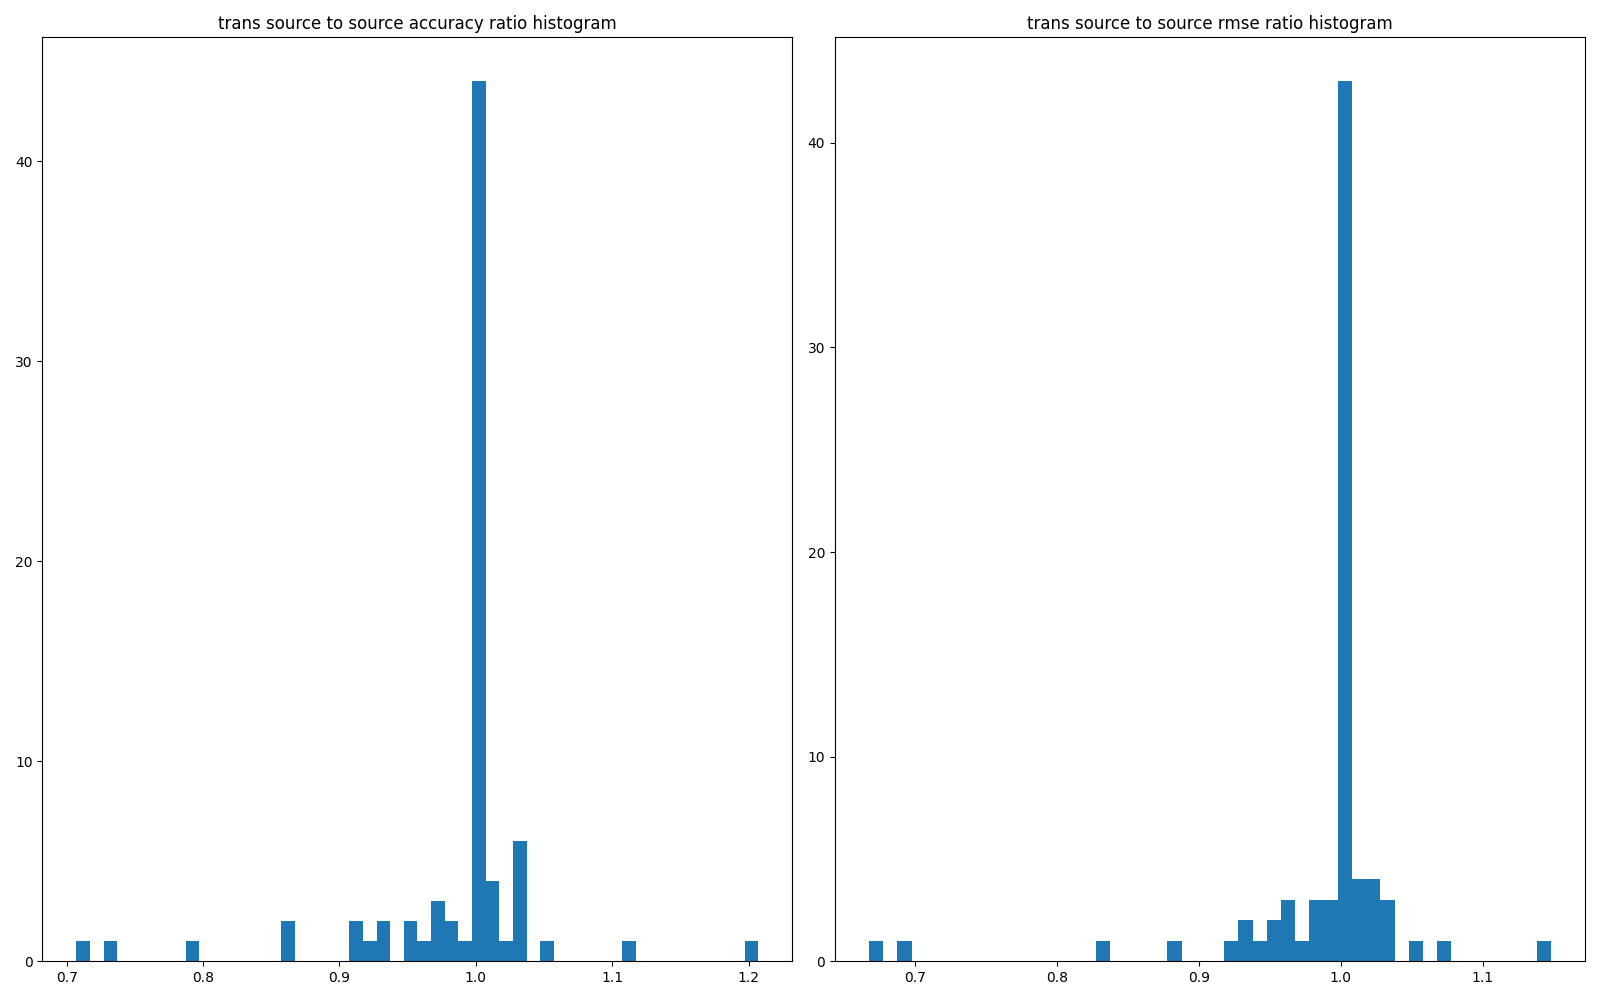

In [17]:
""" 
Smaller is better
"""

hist_plot_cts(score_path)

In [11]:
""" 
Run one iteration
"""

' \nRun one iteration\n'

In [12]:
target_features, target_labels, source_features, source_labels = simulation_wrapper()
target_reps, source_reps = custom_train_reps(target_features, source_features)

# Sinkhorn transport of desired source embedding into desired target embedding
ot_sinkhorn = ot.da.SinkhornTransport(reg_e=1e-1, max_iter=100000)
ot_sinkhorn.fit(Xs=source_reps, Xt=target_reps)
trans_source_reps = ot_sinkhorn.transform(Xs=source_reps)

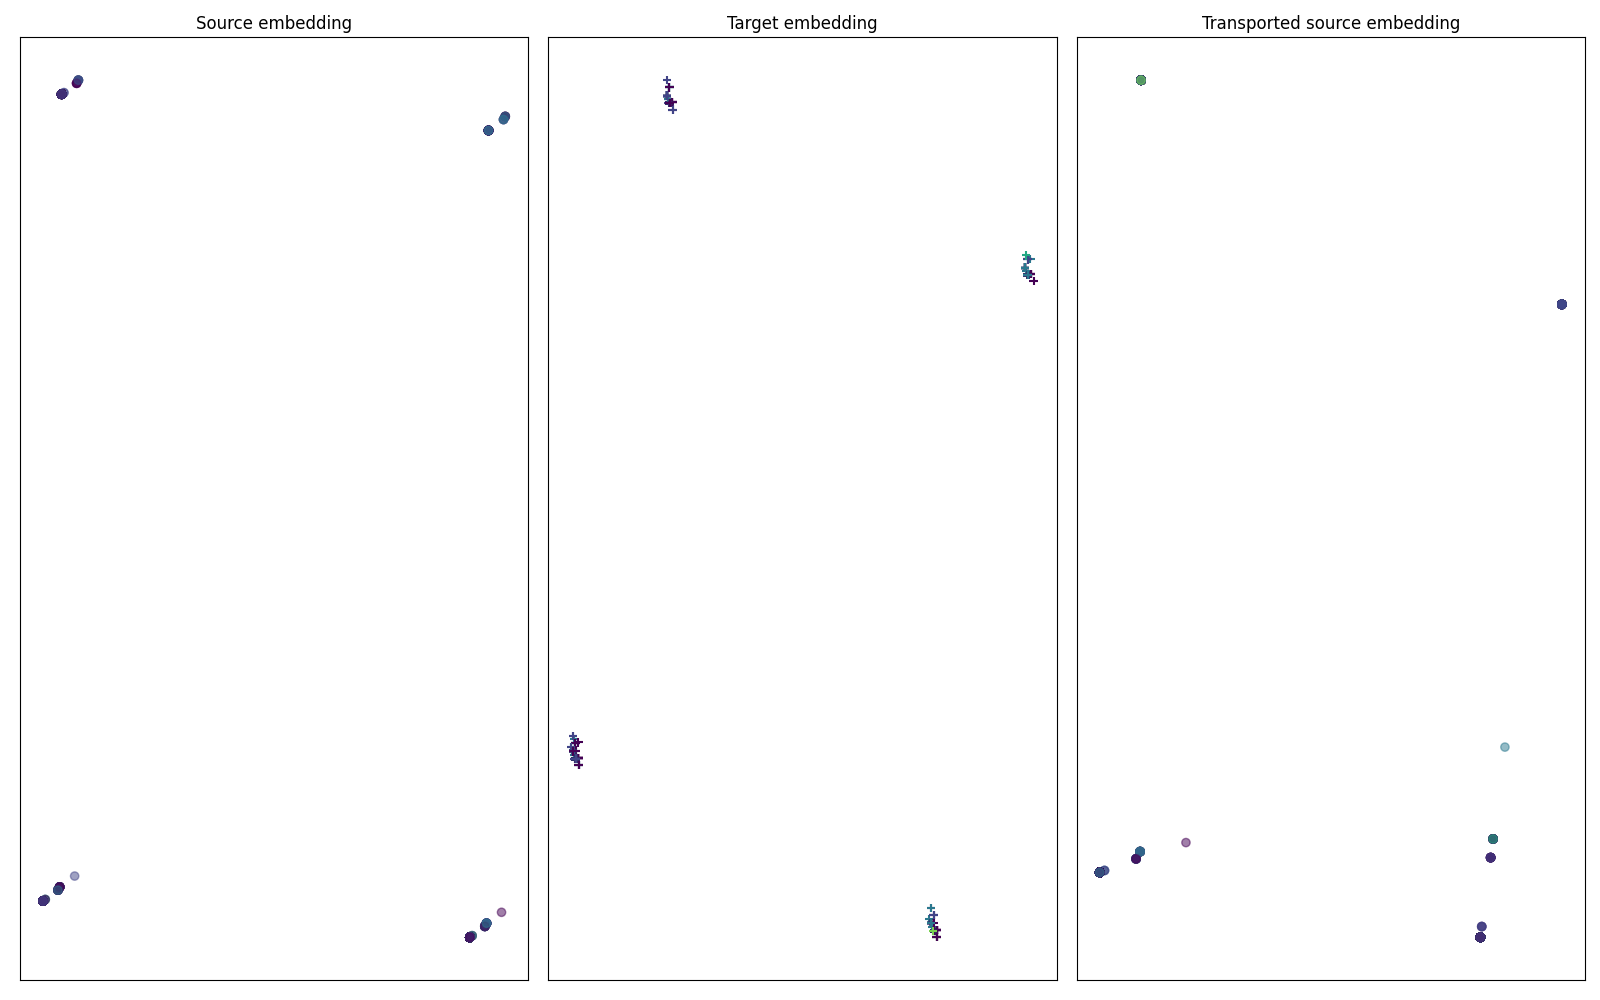

In [13]:
vis_emb_dim2_unordered(target_reps, target_labels, source_reps, source_labels, trans_source_reps)

In [14]:
""" 
Use linear regression to learn, and compute statistics
"""
model_func = linear_model.LinearRegression
target_model = model_func()
target_model.fit(target_reps, target_labels)

# calculate the stats
target_pred_labels = target_model.predict(target_reps)
target_mae = metrics.mean_absolute_error(target_labels, target_pred_labels)
target_rmse = np.sqrt(metrics.mean_squared_error(target_labels, target_pred_labels))

source_pred_labels = target_model.predict(source_reps)
source_mae = metrics.mean_absolute_error(source_labels, source_pred_labels)
source_rmse = np.sqrt(metrics.mean_squared_error(source_labels, source_pred_labels))

trans_source_pred_labels = target_model.predict(trans_source_reps)
trans_source_mae = metrics.mean_absolute_error(source_labels, trans_source_pred_labels)
trans_source_rmse =  np.sqrt(metrics.mean_squared_error(source_labels, trans_source_pred_labels))

In [15]:
print("source_mae is:", source_mae, "source_rmse is:", source_rmse)
print("trans_source_mae is:", trans_source_mae, "trans_source_rmse is:", trans_source_rmse)

source_mae is: 0.7142687069609945 source_rmse is: 0.8865294346815802
trans_source_mae is: 0.7142457925609297 trans_source_rmse is: 0.8863033534702406


IndexError: index 2 is out of bounds for axis 1 with size 2

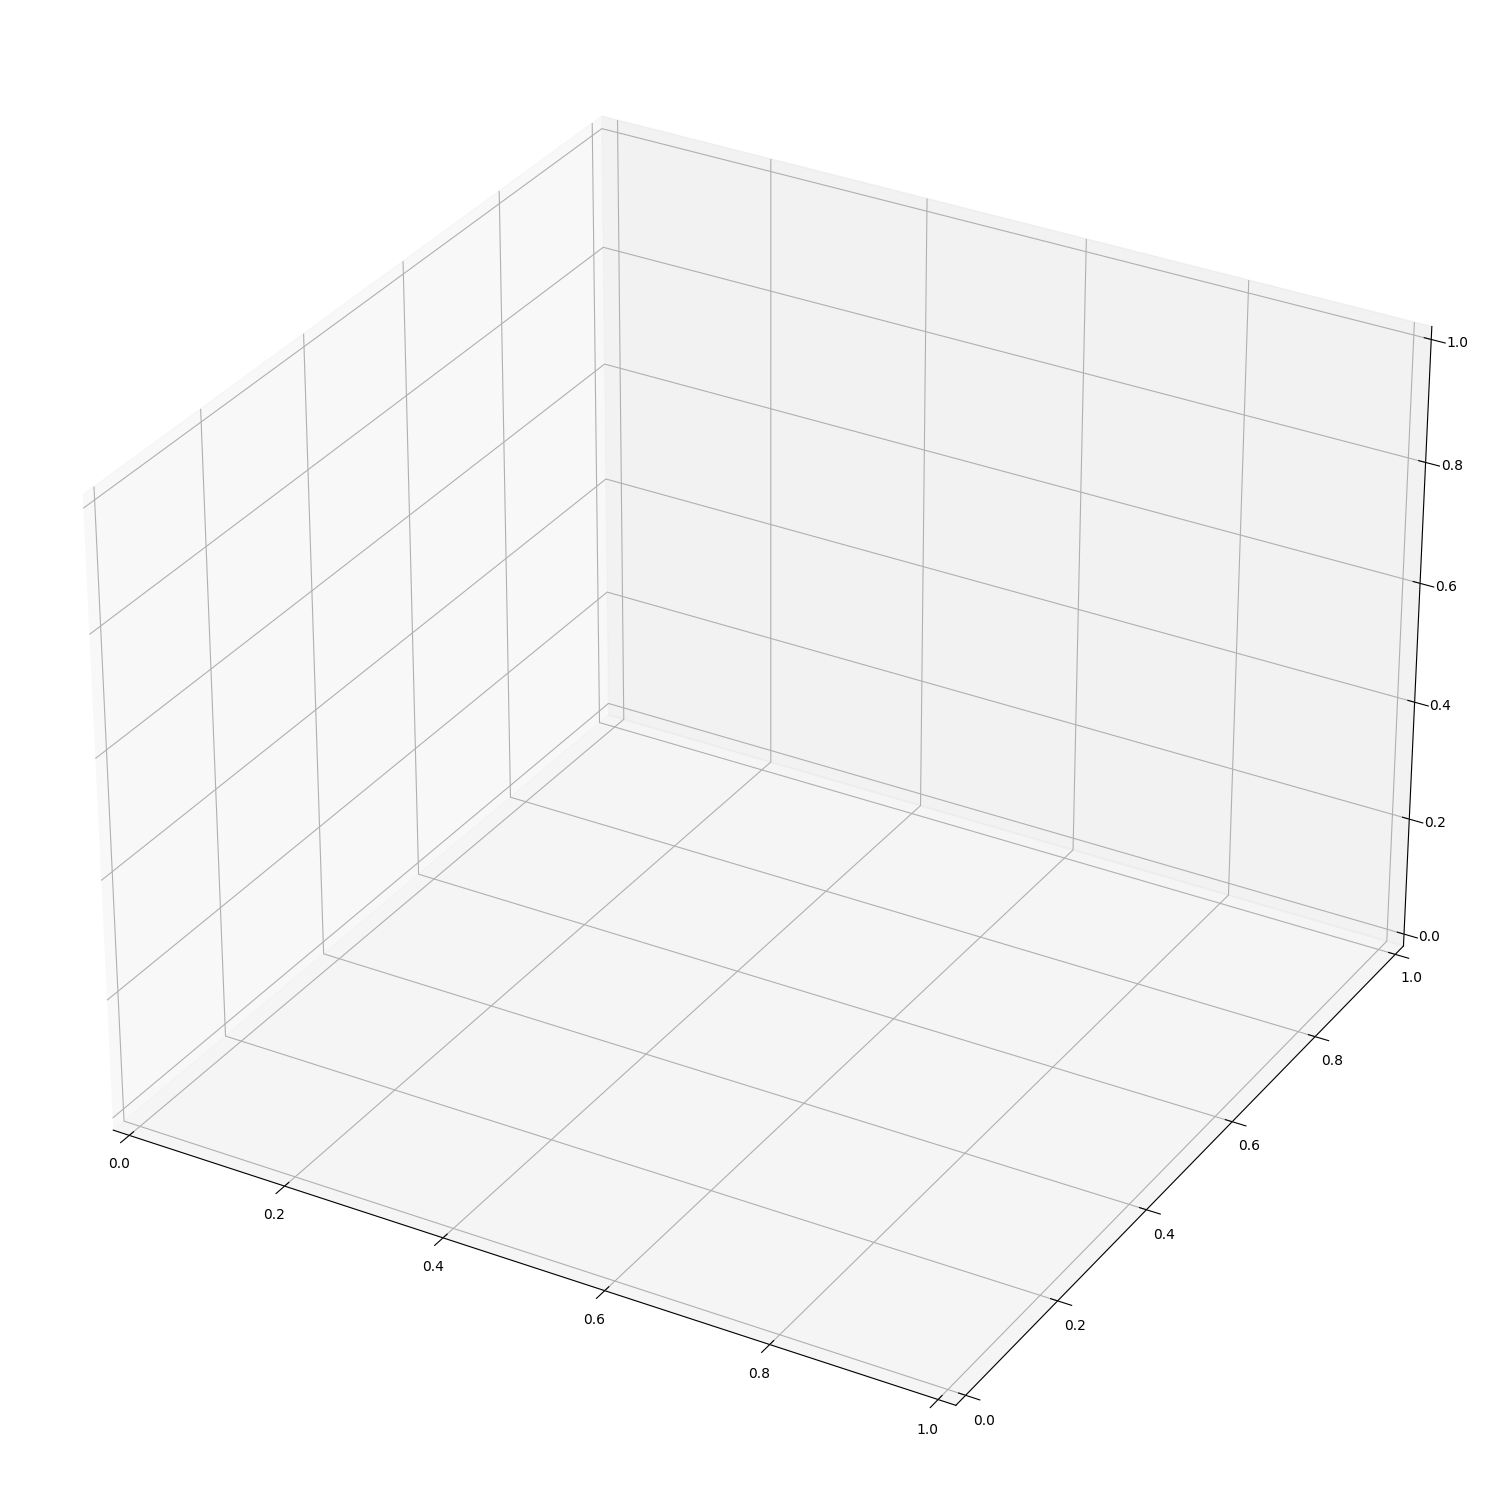

In [16]:
""" 
Draw the linear seperator in 3D space
"""
vis_boundary(target_reps, target_labels, target_model)